#### Import Modules

In [13]:
import pandas as pd
pd.options.plotting.backend = "plotly"

import plotly.express as px
import plotly.graph_objects as go

import numpy as np

from make_new_features import get_df_with_features
from get_krx_value import get_krx_mean

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Preparing Price Dataset

In [14]:
# Very Important Variables !!!
SHORT_PERIOD=5
MID_PERIOD=20
LONG_PERIOD=60

try :
    df_with_feats = pd.read_pickle(f"./df_with_feats_f_20130101_t_20230919_{SHORT_PERIOD}_{MID_PERIOD}_{LONG_PERIOD}.pkl")
    # df_with_feats['date'] = df_with_feats['date'].dt.strftime("%Y-%m-%d")
except :
    # filtering : Normal Stocks, Not SPAC
    df_price = (
        pd.read_pickle("./df_price_price_only_f_20130101_t_20230919.pkl")
        .loc[lambda df : df["code"].str[5]== "0"]
        .loc[lambda df : ~df["name"].str.contains("스펙")]
        .loc[lambda df : ~df["name"].str.contains("스팩")]    
    )

    df_price['date'] = df_price['date'].dt.strftime("%Y-%m-%d")

    try:
        df_krx = pd.read_pickle("./df_krx.pkl")
    except :
        df_krx = get_krx_mean()
        df_krx.to_pickle("./df_krx.pkl")

    df_price = df_price.merge(
        df_krx,
        on='date'
    )
    
    df_with_feats = get_df_with_features(
        df_price, SHORT_PERIOD=SHORT_PERIOD, MID_PERIOD=MID_PERIOD, LONG_PERIOD=LONG_PERIOD)
    df_with_feats.to_pickle(f"./df_with_feats_f_20130101_t_20230919_{SHORT_PERIOD}_{MID_PERIOD}_{LONG_PERIOD}.pkl")

#### Param Studying

In [15]:
# filter set #1 : For param studying

df_filtered = (
    df_with_feats
    .loc[lambda df : df["vol_x_price_sma_long"]*0.8 > df["vol_x_price_sma_mid"]]
    .loc[lambda df : df["vol_x_price_sma_mid"]*0.8 > df["vol_x_price_sma_short"]]

    .loc[lambda df : df["close_std_short"] > df["close_std_long"]*1.1]
    # .loc[lambda df : df["weighted_price_change_std_short"] > df["weighted_price_change_std_mid"]*1.1]
    # .loc[lambda df : df["weighted_price_change_std_mid"] > df["weighted_price_change_std_long"]]

    .loc[lambda df : df["vol_x_price_sma_mid"] > 1e+08] #2.481560e+08
    .loc[lambda df : df["vol_x_price_sma_mid"] < 15e+08] #1.292806e+10
    # .loc[lambda df : df["vol_x_price_sma_long"] >  4.0e+08] #2.481560e+08
    # .loc[lambda df : df["vol_x_price_sma_long"] < 0.1e+10] #1.292806e+10
    
    .loc[lambda df : df["vol_zero_count_long"] < 1]

    .loc[lambda df : df["change"] < 0.29]
    .loc[lambda df : df["volume"] > 0]
)

In [16]:
# filter set #2 : params_max_win_rate
# This params was created using Opuna Optimization

df_filtered = (
    df_with_feats
    .loc[lambda df : df["vol_x_price_sma_long"]*1.0 > df["vol_x_price_sma_mid"]]
    .loc[lambda df : df["vol_x_price_sma_mid"]*0.7 > df["vol_x_price_sma_short"]]

    .loc[lambda df : df["close_std_short"] > df["close_std_long"]*0.60]
    # .loc[lambda df : df["weighted_price_change_std_short"] > df["weighted_price_change_std_mid"]*1.1]
    # .loc[lambda df : df["weighted_price_change_std_mid"] > df["weighted_price_change_std_long"]]

    .loc[lambda df : df["vol_x_price_sma_mid"] > 1.5e+08] #2.481560e+08
    .loc[lambda df : df["vol_x_price_sma_mid"] < 26.59e+08] #1.292806e+10
    # .loc[lambda df : df["vol_x_price_sma_long"] >  4.0e+08] #2.481560e+08
    # .loc[lambda df : df["vol_x_price_sma_long"] < 0.1e+10] #1.292806e+10
    
    .loc[lambda df : df["vol_zero_count_long"] < 1]

    .loc[lambda df : df["change"] < 0.29]
    .loc[lambda df : df["volume"] > 0]

    .loc[lambda df : df["close_change_p_mid"] < -0.25]
)

params_max_win_rate = {
    'close_change_p_mid_upper' : -0.25,
    'close_std_long_fac' : 0.60,
    'vol_x_price_sma_long_fac' : 1.00,
    'vol_x_price_sma_mid_fac' : 0.70,
    'vol_x_price_sma_mid_lower' : 1.5e+08,
    'vol_x_price_sma_mid_upper' : 26.5e+08,
    'sort_ref' : 'close_change_p_mid',
    'sort_order' : True,
    'top_n' : 5,
    'max_holding_date' : 20
}

In [17]:
# filter set #3 : params_max_cumsum_min_std
# This params was created using Opuna Optimization

df_filtered = (
    df_with_feats
    .loc[lambda df : df["vol_x_price_sma_long"]*0.9 > df["vol_x_price_sma_mid"]]
    .loc[lambda df : df["vol_x_price_sma_mid"]*0.65 > df["vol_x_price_sma_short"]]

    .loc[lambda df : df["close_std_short"] > df["close_std_long"]*0.75]

    .loc[lambda df : df["vol_x_price_sma_mid"] > 1e+08] #2.481560e+08
    .loc[lambda df : df["vol_x_price_sma_mid"] < 5.9e+08] #1.292806e+10
    
    .loc[lambda df : df["vol_zero_count_long"] < 1]

    .loc[lambda df : df["change"] < 0.29]
    .loc[lambda df : df["volume"] > 0]

    .loc[lambda df : df["close_change_p_mid"] < 0.35]
)

params_max_cumsum_min_std = {
    'close_change_p_mid_upper' : 0.35,
    'close_std_long_fac' : 0.75,
    'vol_x_price_sma_long_fac' : 0.9,
    'vol_x_price_sma_mid_fac' : 0.65,
    'vol_x_price_sma_mid_lower' : 1e+08,
    'vol_x_price_sma_mid_upper' : 5.9e+08,
    'sort_ref' : 'close_change_p_mid',
    'sort_order' : True,
    'top_n' : 5,
    'max_holding_date' : 20
}

#### EDA

##### Check Distributions

In [18]:
xAxis = "krx_change_p_mid"

if df_filtered.shape[0] > 50000:
    df_ = df_filtered.sample(50000)
else :
    df_ = df_filtered

fig = px.scatter(df_, x=xAxis, y='rtn_20_krx', title=f'{xAxis}')
fig.update_traces(marker=dict(size=2))
# Add a horizontal reference line at Y=10
fig.add_shape(go.layout.Shape(type='line',
                              x0=df_[xAxis].min(),
                              x1=df_[xAxis].max(),
                              y0=0,
                              y1=0,
                              line=dict(color='red', width=2)))

fig.show()

##### Check Cumsum of filtered Dataframe

In [19]:
# Plot cumsum

(
    df_filtered
    .loc[lambda df : df["krx_change_p_short"] < -0.1]
    .sort_values('close_change_p_mid')    
    .groupby("date")
    .head(5)
    .reset_index()
    .groupby('date')
    ["rtn_20_krx"]
    .mean()
    -0.0023
    # + 1
).cumsum().plot(kind='scatter')#sum()#.cumprod().plot()#

#### ML Studying

##### Preparing Dataset : Applying Basic Conditions
- This conditions are used for Production also.
- Do not Change!
- Keep histories

In [20]:
df_with_feats_ml = (
    df_with_feats
    .assign(
        vol_x_price_sma_long_to_mid = lambda df : df.vol_x_price_sma_long / df.vol_x_price_sma_mid,
        vol_x_price_sma_mid_to_short = lambda df : df.vol_x_price_sma_mid / df.vol_x_price_sma_short,
    )
    .loc[lambda df : df["vol_x_price_sma_mid"] >  0.75e+08]  # About 10 percentile
    .loc[lambda df : df["vol_x_price_sma_mid"] <  3.5e+08]  # About 30 percentile
    .loc[lambda df : df["vol_zero_count_long"] < 1]
    .loc[lambda df : df["change"] < 0.29]
    .loc[lambda df : df["volume"] > 0]  
)

In [21]:
df_with_feats["vol_x_price_sma_mid"].quantile([0.1, 0.2, 0.3,0.4, 0.5])

0.1    7.579101e+07
0.2    1.935601e+08
0.3    3.588681e+08
0.4    6.119003e+08
0.5    1.010669e+09
Name: vol_x_price_sma_mid, dtype: float64

##### For Studying

In [22]:
df_train_set = df_with_feats_ml.loc[lambda df : df.date > "2019-01-01"].loc[lambda df : df.date < "2022-12-31"]
df_oos_set = df_with_feats_ml.loc[lambda df : df.date >= "2022-12-31"]

In [23]:
# This features are used both dev and production
# Be carefull to modify !

feats = [            
        # 'vol_x_price_sma_long',
        # 'vol_x_price_sma_mid',
        # 'vol_x_price_sma_short',
        'vol_x_price_sma_long_to_mid',
        'vol_x_price_sma_mid_to_short',
        # 'change_high',
        # 'change_low', 
        # 'change_open',
        'close_std_short',
        'close_std_mid', 
        'close_std_long',
        'open_std_short',
        'open_std_mid',
        'open_std_long',
        'high_std_short', 
        'high_std_mid',
        'high_std_long',
        'low_std_short', 
        'low_std_mid',
        'low_std_long',
        # 'weighted_price_change_std_short', 
        # 'weighted_price_change_std_mid',
        # 'weighted_price_change_std_long',
        # 'vol_zero_count_short',
        # 'vol_zero_count_mid',
        # 'vol_zero_count_long', 
        'close_change_p_short',
        'close_change_p_mid', 
        'close_change_p_long',
        # 'weighted_price_change_p_short',
        # 'weighted_price_change_p_mid',
        # 'weighted_price_change_p_long',
        'krx_corr_short',
        'krx_corr_mid',
        'krx_corr_long',
        'krx_change_p_short',
        'krx_change_p_mid',
        'krx_change_p_long',
        'krx_change_std_short',
        'krx_change_std_mid',
        'krx_change_std_long',
       ]

target = "rtn_5"

In [24]:
df_train_set_ = (
    df_train_set
    # .sample(500)
    .replace([-np.inf, np.inf], np.nan)
    .dropna()
    .reset_index(drop=True)
)

df_oos_set_ = (
    df_oos_set
    # .sample(500)
    .replace([-np.inf, np.inf], np.nan)
    .dropna()
    .reset_index(drop=True)
)


In [25]:
df_train_set_["target"] = (
    df_train_set_[target].apply(lambda x : 1 if x > 0.003 else 0)
)

feature_df = df_train_set_[feats]
target_df = df_train_set_["target"]

target_df.value_counts(normalize=True)

target
0    0.526567
1    0.473433
Name: proportion, dtype: float64

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(
            feature_df, target_df, test_size=0.3, random_state=42
        )

# Create DMatrix for training and validation data
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'max_depth': 5, # Adjust based on your dataset
    'eta': 0.1,     # Learning rate
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Or use 'auc', 'error', etc. based on your problem
    'random_state': 42
}
evals = [(dtrain, 'train'), (dvalid, 'eval')]

num_rounds = 1000
early_stopping_rounds = 50  # Stops training if validation metric doesn't improve for 50 rounds

model = xgb.train(
    params, dtrain,
    num_rounds,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

In [27]:
# Check train score

y_pred = model.predict(dvalid)
y_pred_binary = [1 if pred > 0.35 else 0 for pred in y_pred]  # Convert probabilities to binary labels

# # Calculate other evaluation metrics
accuracy = accuracy_score(y_valid, y_pred_binary)
precision = precision_score(y_valid, y_pred_binary)
recall = recall_score(y_valid, y_pred_binary)
f1 = f1_score(y_valid, y_pred_binary)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.47269414535340126
Precision: 0.47269414535340126
Recall: 1.0
F1 Score: 0.6419447606888791


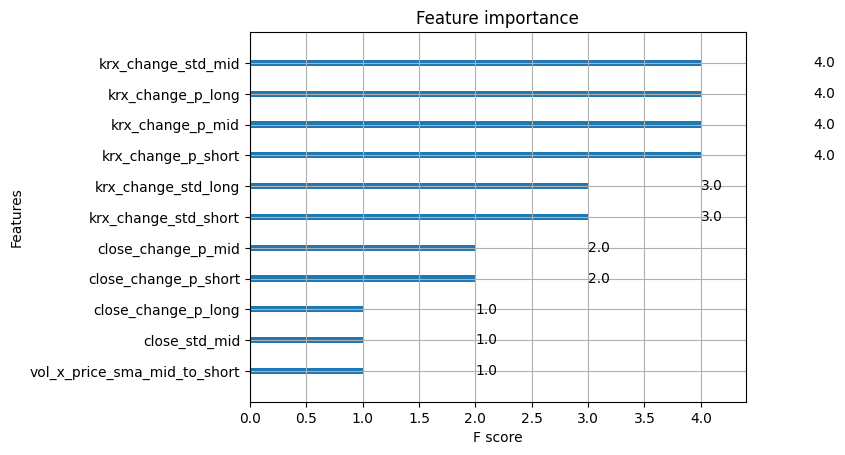

In [28]:
# Check Feature Importance 

importance = model.get_score(importance_type='weight')

from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.show();

In [29]:
# # Check valid set performance

# bool_mask = [bool(x) for x in y_pred_binary]
# index_of_true = y_valid[bool_mask].index

# (
#     df_train_set_
#     .iloc[index_of_true]
#     .sort_values('close_change_p_mid', ascending=True)    
#     .groupby('date')
#     .head()
#     .reset_index()
#     .groupby('date')[target]
#     .mean()
#     -0.0023
# ).cumsum().plot()

##### OOS Verification

In [30]:
df_oos_set_["target"] = (
    df_oos_set_[target].apply(lambda x : 1 if x > 0.003 else 0)
)

feature_df_oos = df_oos_set_[feats]
target_df_oos = df_oos_set_["target"]

doos = xgb.DMatrix(feature_df_oos)

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

In [31]:
# Check OOS performance : Scores

y_pred_oos = model.predict(doos)
# print(y_pred_oos.max())
y_pred_oos_binary = [1 if pred > 0.3 else 0 for pred in y_pred_oos]  # Convert probabilities to binary labels

# # Calculate other evaluation metrics
accuracy = accuracy_score(target_df_oos, y_pred_oos_binary)
precision = precision_score(target_df_oos, y_pred_oos_binary)
recall = recall_score(target_df_oos, y_pred_oos_binary)
f1 = f1_score(target_df_oos, y_pred_oos_binary)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.4388888888888889
Precision: 0.4388888888888889
Recall: 1.0
F1 Score: 0.61003861003861


In [32]:
# Check OOS performance : Cumsum Plot

bool_mask_oos = [bool(x) for x in y_pred_oos_binary]
index_of_true_oos = target_df_oos[bool_mask_oos].index

(
    df_oos_set_
    .iloc[index_of_true_oos]
    .sort_values('close_change_p_mid', ascending=False)    
    # .sort_values('close_std_short', ascending=False)
    .groupby('date')
    .head(10)
    .reset_index()
    .groupby('date')[target]
    .mean()
    -0.0023
    # +1
).cumsum().plot(kind='scatter')

### ML Walking Forward Validation

##### Create Date List

In [33]:
# For cumulative train dataset

import exchange_calendars as xcals
krx_cal = xcals.get_calendar("XKRX")

max_date = '2023-07-01'
start_date = '2015-01-02'

finish = False
dates = []
i = 600 # Number of the first train dataset length (business days) 
gap_from_last_train_date = 6 # This number depends on the target ( rtn_5 -> 6, rnt_20 -> 21)
len_of_pred = 61 # The length of pred for 1 model update

while not finish :
    train_end = krx_cal.sessions_window(start_date, i)[-1].strftime("%Y-%m-%d")
    oos_start = krx_cal.sessions_window(train_end, gap_from_last_train_date)[-1].strftime("%Y-%m-%d") # 
    oos_end = krx_cal.sessions_window(oos_start, len_of_pred)[-1].strftime("%Y-%m-%d")

    if oos_end > max_date :
        finish = True
        
    else :
        dates.append(
            (start_date, train_end, oos_start, oos_end)
        )

        # start_date = krx_cal.sessions_window(start_date, 5)[-1].strftime("%Y-%m-%d")
        i = i + len_of_pred - 1



In [34]:
# Check Result
# dates[0:5]
dates[-5:]

[('2015-01-02', '2022-01-25', '2022-02-04', '2022-05-03'),
 ('2015-01-02', '2022-04-26', '2022-05-03', '2022-07-29'),
 ('2015-01-02', '2022-07-22', '2022-07-29', '2022-10-28'),
 ('2015-01-02', '2022-10-21', '2022-10-28', '2023-01-25'),
 ('2015-01-02', '2023-01-16', '2023-01-25', '2023-04-20')]

In [50]:
# For fixed length train dataset

import exchange_calendars as xcals
krx_cal = xcals.get_calendar("XKRX")

max_date = '2024-02-30'
start_date = '2015-01-02'

finish = False
dates = []

len_of_train = 300
gap_from_last_train_date = 7 # This number depends on the target ( rtn_5 -> 7, rnt_20 -> 22)
len_of_pred = 20 # The length of pred for 1 model update

while not finish :
    train_end = krx_cal.sessions_window(start_date, len_of_train)[-1].strftime("%Y-%m-%d")
    oos_start = krx_cal.sessions_window(train_end, gap_from_last_train_date)[-1].strftime("%Y-%m-%d")
    oos_end = krx_cal.sessions_window(oos_start, len_of_pred)[-1].strftime("%Y-%m-%d")

    if oos_end > max_date :
        finish = True
        
    else :
        dates.append(
            (start_date, train_end, oos_start, oos_end)
        )

        start_date = krx_cal.sessions_window(start_date, len_of_pred)[-1].strftime("%Y-%m-%d")



In [51]:
dates[-5:]

[('2022-06-30', '2023-09-12', '2023-09-20', '2023-10-23'),
 ('2022-07-27', '2023-10-13', '2023-10-23', '2023-11-17'),
 ('2022-08-24', '2023-11-09', '2023-11-17', '2023-12-14'),
 ('2022-09-22', '2023-12-06', '2023-12-14', '2024-01-15'),
 ('2022-10-21', '2024-01-05', '2024-01-15', '2024-02-13')]

In [37]:
import json
import pickle

In [42]:
# RUN WFV

THRES_OF_TRUE = 0.003

l_sr_selected = []
l_of_oos_with_proba = []
cumsum = 0

for train_start, train_end, oos_start, oos_end in dates:

    df_train_set = df_with_feats_ml.loc[lambda df : df.date >= train_start].loc[lambda df : df.date < train_end]
    df_oos_set = df_with_feats_ml.loc[lambda df : df.date >= oos_start].loc[lambda df : df.date < oos_end]

    df_train_set_ = (
        df_train_set
        .replace([-np.inf, np.inf], np.nan)
        .dropna()
        .reset_index(drop=True)
    )

    df_oos_set_ = (
        df_oos_set
        .replace([-np.inf, np.inf], np.nan)
        .dropna()
        .reset_index(drop=True)
    )

    df_train_set_["target"] = (
        df_train_set_[target].apply(lambda x : 1 if x > THRES_OF_TRUE else 0)
    )

    feature_df = df_train_set_[feats]
    target_df = df_train_set_["target"]

    l_of_models = [] 
    for rnd_seed in [6, 13, 5, 2]:
        X_train, X_valid, y_train, y_valid = train_test_split(
            feature_df, target_df, test_size=0.3, random_state=rnd_seed
        )

        # Create DMatrix for training and validation data
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        evals = [(dtrain, 'train'), (dvalid, 'eval')]

        params = {
            'max_depth': 8, # Adjust based on your dataset : originally 5 --> try 8
            'eta': 0.05,     # Learning rate : originally 0.05
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',  # Or use 'auc', 'error', etc. based on your problem
            'random_state': 42
        }

        model = xgb.train(
            params, dtrain,
            1000,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=False
        )

        l_of_models.append(model)
    
    # with open("model_list_pickle.pkl", "wb") as f:
    #     pickle.dump(l_of_models, f)

    df_oos_set_["target"] = (
        df_oos_set_[target].apply(lambda x : 1 if x > THRES_OF_TRUE else 0)
    )

    feature_df_oos = df_oos_set_[feats]
    target_df_oos = df_oos_set_["target"]

    doos = xgb.DMatrix(feature_df_oos)

    cols = []
    for id, model in enumerate(l_of_models):
        cols.append(f"pred_{id}")
        df_oos_set_[f"pred_{id}"] = model.predict(doos)

    df_oos_set_["proba_mean"] = df_oos_set_[cols].mean(axis=1)
    df_oos_set_["proba_min"] = df_oos_set_[cols].min(axis=1)
    df_oos_set_["proba_max"] = df_oos_set_[cols].max(axis=1)

    l_of_oos_with_proba.append(
        df_oos_set_
    )

    sr_selected = (
        df_oos_set_
        .loc[lambda df : df['proba_mean'] > 0.6]
        .loc[lambda df : df['proba_min'] > 0.6]
        .sort_values('close_change_p_mid', ascending=True)   
        .groupby('date')
        .head(5)
        .reset_index()
        .groupby('date')[target]
        .mean()
        -0.0023
    )
    l_sr_selected.append(sr_selected)

    cumsum += sr_selected.sum()

    print(
        f"Train : {train_start}~{train_end} / OOS : {oos_start}~{oos_end} / Gain : {sr_selected.sum()} / No. of Date : {sr_selected.shape[0]} / Cumsum : {cumsum}"
    )


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-01-02~2016-03-21 / OOS : 2016-03-28~2016-04-25 / Gain : 0.20885248737230627 / No. of Date : 13 / Cumsum : 0.20885248737230627


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-01-29~2016-04-18 / OOS : 2016-04-25~2016-05-24 / Gain : -0.8087753759826918 / No. of Date : 19 / Cumsum : -0.5999228886103856


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-03-02~2016-05-17 / OOS : 2016-05-24~2016-06-21 / Gain : 0.7899224269703519 / No. of Date : 15 / Cumsum : 0.1899995383599663


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-03-27~2016-06-14 / OOS : 2016-06-21~2016-07-18 / Gain : 0.3087568195909303 / No. of Date : 18 / Cumsum : 0.4987563579508966


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-04-23~2016-07-11 / OOS : 2016-07-18~2016-08-12 / Gain : 0.07509226697126645 / No. of Date : 10 / Cumsum : 0.573848624922163


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-05-22~2016-08-05 / OOS : 2016-08-12~2016-09-09 / Gain : -0.20230968610950323 / No. of Date : 18 / Cumsum : 0.3715389388126598


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-06-19~2016-09-02 / OOS : 2016-09-09~2016-10-12 / Gain : 0.42335181515684495 / No. of Date : 10 / Cumsum : 0.7948907539695047


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-07-16~2016-10-05 / OOS : 2016-10-12~2016-11-08 / Gain : 0.29767164381665423 / No. of Date : 15 / Cumsum : 1.092562397786159


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-08-12~2016-11-01 / OOS : 2016-11-08~2016-12-05 / Gain : 0.2586647594892257 / No. of Date : 19 / Cumsum : 1.3512271572753847


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-09-09~2016-11-28 / OOS : 2016-12-05~2017-01-02 / Gain : 0.46200569986498036 / No. of Date : 4 / Cumsum : 1.813232857140365


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-10-08~2016-12-23 / OOS : 2017-01-02~2017-01-31 / Gain : -0.15636053194020394 / No. of Date : 17 / Cumsum : 1.6568723252001611


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-11-05~2017-01-20 / OOS : 2017-01-31~2017-02-27 / Gain : 0.18908209735030063 / No. of Date : 12 / Cumsum : 1.8459544225504618


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-12-02~2017-02-20 / OOS : 2017-02-27~2017-03-27 / Gain : 0.02508689799072347 / No. of Date : 5 / Cumsum : 1.8710413205411853


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2015-12-30~2017-03-20 / OOS : 2017-03-27~2017-04-21 / Gain : 0.13616195348614846 / No. of Date : 15 / Cumsum : 2.007203274027334


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-01-28~2017-04-14 / OOS : 2017-04-21~2017-05-24 / Gain : 0.011998740551747343 / No. of Date : 17 / Cumsum : 2.019202014579081


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-02-29~2017-05-17 / OOS : 2017-05-24~2017-06-21 / Gain : 0.15098593451016992 / No. of Date : 10 / Cumsum : 2.170187949089251


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-03-28~2017-06-14 / OOS : 2017-06-21~2017-07-18 / Gain : -0.04483187785039715 / No. of Date : 13 / Cumsum : 2.125356071238854


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-04-25~2017-07-11 / OOS : 2017-07-18~2017-08-14 / Gain : -0.07994151451858661 / No. of Date : 14 / Cumsum : 2.0454145567202673


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-05-24~2017-08-07 / OOS : 2017-08-14~2017-09-11 / Gain : -0.09786198940051272 / No. of Date : 17 / Cumsum : 1.9475525673197547


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-06-21~2017-09-04 / OOS : 2017-09-11~2017-10-16 / Gain : -0.08604277234831581 / No. of Date : 17 / Cumsum : 1.8615097949714388


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-07-18~2017-09-29 / OOS : 2017-10-16~2017-11-10 / Gain : 0.6242681380141449 / No. of Date : 19 / Cumsum : 2.4857779329855836


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-08-12~2017-11-03 / OOS : 2017-11-10~2017-12-07 / Gain : 0.1990164227199691 / No. of Date : 19 / Cumsum : 2.6847943557055527


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-09-09~2017-11-30 / OOS : 2017-12-07~2018-01-08 / Gain : 0.29410250165112706 / No. of Date : 18 / Cumsum : 2.9788968573566796


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-10-12~2017-12-28 / OOS : 2018-01-08~2018-02-02 / Gain : 0.4456196254400794 / No. of Date : 19 / Cumsum : 3.424516482796759


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-11-08~2018-01-26 / OOS : 2018-02-02~2018-03-06 / Gain : 0.3477047204094041 / No. of Date : 19 / Cumsum : 3.772221203206163


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2016-12-05~2018-02-26 / OOS : 2018-03-06~2018-04-02 / Gain : -0.2740237091542969 / No. of Date : 15 / Cumsum : 3.4981974940518663


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-01-02~2018-03-26 / OOS : 2018-04-02~2018-04-27 / Gain : 1.529852814265766 / No. of Date : 16 / Cumsum : 5.028050308317632


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-01-31~2018-04-20 / OOS : 2018-04-27~2018-05-29 / Gain : -0.1930791776437572 / No. of Date : 16 / Cumsum : 4.834971130673875


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-02-27~2018-05-21 / OOS : 2018-05-29~2018-06-27 / Gain : -0.12140195201292764 / No. of Date : 18 / Cumsum : 4.713569178660947


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-03-27~2018-06-20 / OOS : 2018-06-27~2018-07-24 / Gain : 0.7925178209224617 / No. of Date : 19 / Cumsum : 5.506086999583409


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-04-21~2018-07-17 / OOS : 2018-07-24~2018-08-21 / Gain : 0.5406618290703755 / No. of Date : 10 / Cumsum : 6.046748828653785


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-05-24~2018-08-13 / OOS : 2018-08-21~2018-09-17 / Gain : -0.016295983334289724 / No. of Date : 15 / Cumsum : 6.030452845319495


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-06-21~2018-09-10 / OOS : 2018-09-17~2018-10-19 / Gain : -0.2921590169161413 / No. of Date : 16 / Cumsum : 5.738293828403354


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-07-18~2018-10-12 / OOS : 2018-10-19~2018-11-15 / Gain : 0.31731499570726923 / No. of Date : 19 / Cumsum : 6.055608824110623


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-08-14~2018-11-08 / OOS : 2018-11-15~2018-12-12 / Gain : 0.03916796680849814 / No. of Date : 19 / Cumsum : 6.094776790919121


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-09-11~2018-12-05 / OOS : 2018-12-12~2019-01-11 / Gain : 0.0777359607843108 / No. of Date : 14 / Cumsum : 6.172512751703431


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-10-16~2019-01-04 / OOS : 2019-01-11~2019-02-12 / Gain : 0.30828502148703196 / No. of Date : 7 / Cumsum : 6.480797773190464


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-11-10~2019-01-31 / OOS : 2019-02-12~2019-03-12 / Gain : -0.14811572439536985 / No. of Date : 15 / Cumsum : 6.332682048795093


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2017-12-07~2019-03-05 / OOS : 2019-03-12~2019-04-08 / Gain : 0.3475291457943174 / No. of Date : 6 / Cumsum : 6.680211194589411


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-01-08~2019-04-01 / OOS : 2019-04-08~2019-05-07 / Gain : 0.12733090278443482 / No. of Date : 4 / Cumsum : 6.807542097373846


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-02-02~2019-04-26 / OOS : 2019-05-07~2019-06-03 / Gain : 0.0583206695966445 / No. of Date : 10 / Cumsum : 6.865862766970491


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-03-06~2019-05-27 / OOS : 2019-06-03~2019-07-01 / Gain : 0.08116022427440622 / No. of Date : 2 / Cumsum : 6.947022991244896


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-04-02~2019-06-24 / OOS : 2019-07-01~2019-07-26 / Gain : -0.16014499265100376 / No. of Date : 5 / Cumsum : 6.7868779985938925


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-04-27~2019-07-19 / OOS : 2019-07-26~2019-08-23 / Gain : -0.016856705136075435 / No. of Date : 13 / Cumsum : 6.770021293457817


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-05-29~2019-08-16 / OOS : 2019-08-23~2019-09-23 / Gain : 0.5252751094404142 / No. of Date : 19 / Cumsum : 7.295296402898231


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-06-27~2019-09-16 / OOS : 2019-09-23~2019-10-22 / Gain : 0.2564004217936532 / No. of Date : 19 / Cumsum : 7.551696824691884


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-07-24~2019-10-15 / OOS : 2019-10-22~2019-11-18 / Gain : 0.35677729161696814 / No. of Date : 19 / Cumsum : 7.908474116308852


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-08-21~2019-11-11 / OOS : 2019-11-18~2019-12-13 / Gain : 0.42221790041887913 / No. of Date : 9 / Cumsum : 8.330692016727731


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-09-17~2019-12-06 / OOS : 2019-12-13~2020-01-14 / Gain : 0.01217426714292494 / No. of Date : 15 / Cumsum : 8.342866283870656


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-10-19~2020-01-07 / OOS : 2020-01-14~2020-02-12 / Gain : 0.2287139447766921 / No. of Date : 19 / Cumsum : 8.571580228647347


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-11-15~2020-02-05 / OOS : 2020-02-12~2020-03-10 / Gain : -1.392266470781038 / No. of Date : 19 / Cumsum : 7.179313757866309


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2018-12-12~2020-03-03 / OOS : 2020-03-10~2020-04-06 / Gain : 1.3880794579329752 / No. of Date : 19 / Cumsum : 8.567393215799283


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2019-01-11~2020-03-30 / OOS : 2020-04-06~2020-05-07 / Gain : 0.5625366435246404 / No. of Date : 8 / Cumsum : 9.129929859323923


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2019-02-12~2020-04-27 / OOS : 2020-05-07~2020-06-03 / Gain : 0.2821158434661158 / No. of Date : 19 / Cumsum : 9.412045702790039


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2019-03-12~2020-05-27 / OOS : 2020-06-03~2020-06-30 / Gain : -0.18847988707321545 / No. of Date : 11 / Cumsum : 9.223565815716823


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2019-04-08~2020-06-23 / OOS : 2020-06-30~2020-07-27 / Gain : 0.0 / No. of Date : 0 / Cumsum : 9.223565815716823


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

Train : 2019-05-07~2020-07-20 / OOS : 2020-07-27~2020-08-24 / Gain : 0.08636073845293697 / No. of Date : 19 / Cumsum : 9.30992655416976


c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\stop2\Documents\Codes\01_Axolotls_Investment\model-dev-and-management\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. U

KeyboardInterrupt: 

##### Plot WFV Result

In [40]:
df_prd_oos = pd.concat(l_sr_selected).to_frame().reset_index().drop_duplicates(subset="date").set_index('date')
print(f"No. of Dates : {df_prd_oos.shape[0]}")
df_prd_oos['rtn_5'].cumsum().plot(kind="scatter")

No. of Dates : 56


### 23. 12. 03 요약

- volume x price sma mid 기준 40억 이상은 예측이 어렵다

### Optuna

In [ ]:
import optuna

def objective3(trial):
    fac1 = trial.suggest_float("vol_x_price_sma_long_fac", 0.5, 1.0, step=0.05)
    fac2 = trial.suggest_float("vol_x_price_sma_mid_fac", 0.5, 1.0, step=0.05)
    fac3 = trial.suggest_float("close_std_long_fac", 0.5, 2.0, step=0.05)
    fac4 = trial.suggest_int("vol_x_price_sma_mid_lower", 1e+08, 5e+08, step=0.1e+08)
    fac5 = trial.suggest_int("vol_x_price_sma_mid_upper", 5e+08, 30e+08, step=0.1e+08)
    fac6 = trial.suggest_float("close_change_p_mid_upper", -0.5, 0.4, step=0.05)

    df_filtered = (
        df_with_feats
        .loc[lambda df : df["vol_x_price_sma_long"]*fac1 > df["vol_x_price_sma_mid"]]
        .loc[lambda df : df["vol_x_price_sma_mid"]*fac2> df["vol_x_price_sma_short"]]

        .loc[lambda df : df["close_std_short"] > df["close_std_long"]*fac3]

        .loc[lambda df : df["vol_x_price_sma_mid"] > fac4] #1e+08
        .loc[lambda df : df["vol_x_price_sma_mid"] < fac5] #15e+08
        
        .loc[lambda df : df["vol_zero_count_long"] < 1]

        .loc[lambda df : df["change"] < 0.29]
        .loc[lambda df : df["volume"] > 0]

        .loc[lambda df : df["close_change_p_mid"] < fac6]
        .dropna()
    )

    sr = (
        df_filtered
        .sort_values('close_change_p_mid')    
        .groupby("date")
        .head(5)
        .reset_index()
        .groupby('date')
        ["rtn_20"]
        .mean()
        -0.0023
    )

    cumsum = (
        df_filtered
        .sort_values('close_change_p_mid')    
        .groupby("date")
        .head(5)
        .reset_index()
        .groupby('date')
        ["rtn_20"]
        .mean()
        -0.0023
    ).sum()

    std = (
        df_filtered
        .sort_values('close_change_p_mid')    
        .groupby("date")
        .head(5)
        .reset_index()
        .groupby('date')
        ["rtn_20"]
        .mean()
        -0.0023
    ).std()

    if df_filtered.date.unique().__len__() < df_with_feats.date.unique().__len__() * 0.3:
            raise optuna.exceptions.TrialPruned() 

    above_plus = sr.apply(lambda x : 1 if x > 0 else 0).sum()
    total = sr.shape[0]
    win_rate = (above_plus / total)

    # return cumsum, std
    return win_rate

In [ ]:

# Optuna Strudy Run
def run_optuna(name):

    study = optuna.create_study(
            direction="maximize",
            # directions=["maximize", "minimize"],
            study_name=name,
            # storage=postgresql_storage,
            # load_if_exists=True,
        )

    study.optimize(
        lambda trial : objective3(trial),
        n_trials=2000,
        show_progress_bar=True,
    )

    # Create study result df & Save to file
    df_study_result = (
        study.trials_dataframe()
        .rename(columns = lambda x : x.replace("params_", ""))
    )    
    df_study_result.to_pickle(f"./study_result_20231208_{name}.pkl")

In [ ]:
run_optuna("max_win_rate")

In [ ]:
df_study = (
    pd.read_pickle("./study_result_20231208_test01.pkl")
    .dropna()
)

In [ ]:
df_study.columns

In [ ]:
df_study.plot(x="number", y="value", kind="scatter")

In [ ]:
(
    df_study
    .loc[lambda df : df.values_1 < 0.103499 ]
    .loc[lambda df : df.values_0 > 39.236776 - 7.048770]
    .loc[lambda df : df.values_0 < 39.236776 + 7.048770]
).sort_values('values_0').tail(10)#.to_dict()

### Conditions



In [ ]:
params_max_win_rate = {
    'close_change_p_mid_upper' : -0.25,
    'close_std_long_fac' : 0.60,
    'vol_x_price_sma_long_fac' : 1.00,
    'vol_x_price_sma_mid_fac' : 0.70,
    'vol_x_price_sma_mid_lower' : 1.5e+08,
    'vol_x_price_sma_mid_upper' : 26.5e+08,
    'sort_ref' : 'close_change_p_mid',
    'sort_order' : True,
    'top_n' : 5,
    'max_holding_date' : 20
}
# 23-12-07

In [ ]:
params_max_cumsum_min_std = {
    'close_change_p_mid_upper' : 0.35,
    'close_std_long_fac' : 0.75,
    'vol_x_price_sma_long_fac' : 0.9,
    'vol_x_price_sma_mid_fac' : 0.65,
    'vol_x_price_sma_mid_lower' : 1e+08,
    'vol_x_price_sma_mid_upper' : 5.9e+08,
    'sort_ref' : 'close_change_p_mid',
    'sort_order' : True,
    'top_n' : 5,
    'max_holding_date' : 20
}
# 23-12-07